In [1]:
import os, sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import cv2
import osgeo.gdal as gdal
from geotiff import GeoTiff

# Recortes Urbano No Urbano

In [2]:
no_maleza_files_v = glob.glob(r'.\no_maleza\*.tif') 
maleza_files_v = glob.glob(r'.\maleza\*.tif')

In [3]:
len (maleza_files_v)

50

In [4]:
len(no_maleza_files_v)

50

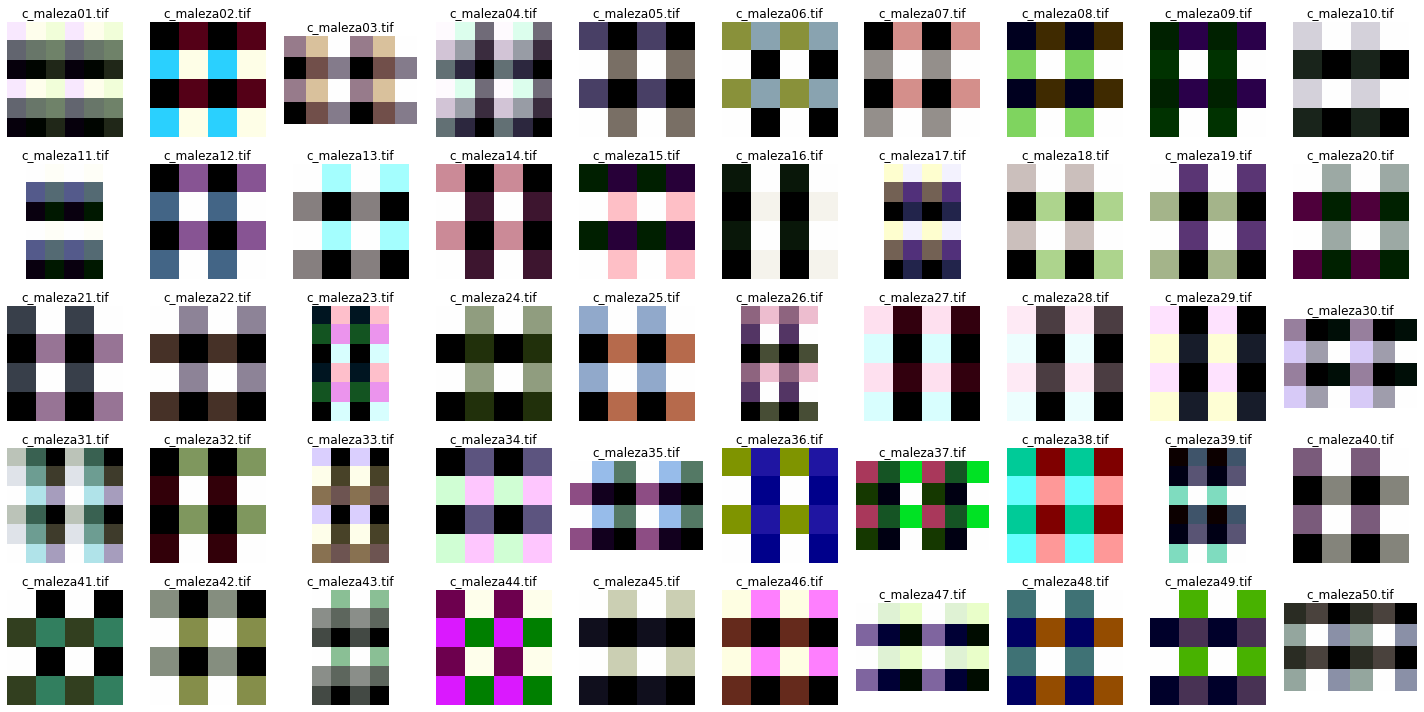

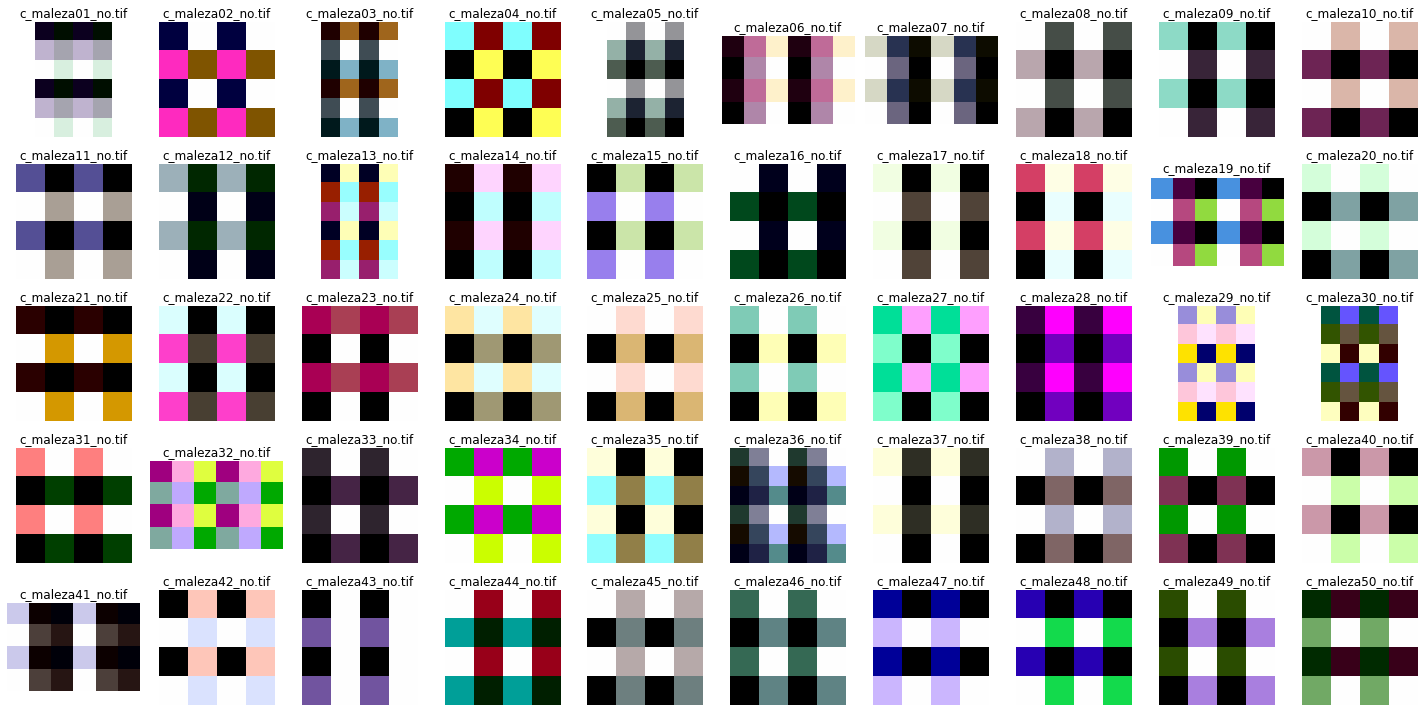

In [5]:
def read_samples(paths_v=maleza_files_v):
    n_cols = 10
    n_rows_f = len( paths_v ) / n_cols

    n_rows = round(n_rows_f)
    if n_rows_f > n_rows:
        n_rows = n_rows + 1
    
    n_bands = None
    samples_v = []
    f, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,10))
    for i, fp in enumerate(paths_v):
        escena = GeoTiff(fp)
        escena_zc = escena.read()
        escena_np = escena_zc[:]
        
        samples_v.append(escena_np)
        
        r, c = divmod(i, n_cols)
        
        ax = axes[r,c]
        
        
        escena_np_flat = escena_np.reshape( (-1, escena_np.shape[-1]) )
        max_band_v = escena_np_flat.max(axis=0)
        min_band_v = escena_np_flat.min(axis=0)
        
        escena_np_scaled = (escena_np-min_band_v)/(max_band_v - min_band_v+1e-8)
        
        if (n_bands is not None) and (escena_np_scaled.shape[2] != n_bands):
            print( f' - ERROR: {os.path.basename(fp)} parece tener un número distinto de bandas. n_bandas = {escena_np_scaled.shape[2]}' )
            
        n_bands = escena_np_scaled.shape[2]
        bands_idx_v = np.arange(n_bands)

        if n_bands > 12:
            bands_idx_v = bands_idx_v[:12]
            
        elif n_bands < 12:
            bands_idx_v = list(bands_idx_v) + [bands_idx_v[i % n_bands] for i in range(12 - n_bands)]
            bands_idx_v = np.array(bands_idx_v)
    
        img = np.concatenate( 
            [
                np.concatenate( [escena_np_scaled[:,:,bands_idx_v[0:3]], escena_np_scaled[:,:,bands_idx_v[3:6 ]]], axis=1 ),
                np.concatenate( [escena_np_scaled[:,:,bands_idx_v[6:9]], escena_np_scaled[:,:,bands_idx_v[9:12]]], axis=1 )
            ], 
            axis=0
        )
        ax.imshow( img )

        ax.set_title(os.path.basename(fp))

        ax.axis('off')

    f.tight_layout()
    plt.show()
    
    return samples_v


maleza_samples_v = read_samples(paths_v=maleza_files_v)

no_maleza_samples_v = read_samples(paths_v=no_maleza_files_v)

In [6]:
ds = {
    'input': [],
    'target': [],
}

for i, escena_np in enumerate(maleza_samples_v):
    escena_np = escena_np.reshape( (-1, escena_np.shape[2]) )
    
    ds['input'].extend(escena_np)
    ds['target'].extend(np.ones(escena_np.shape[0], dtype=np.int64))
    

for i, escena_np in enumerate(no_maleza_samples_v):
    escena_np = escena_np.reshape( (-1, escena_np.shape[2]) )
    
    ds['input'].extend(escena_np)
    ds['target'].extend(np.zeros(escena_np.shape[0], dtype=np.int64))

In [7]:
for k in ds.keys():
    ds[k] = np.array(ds[k])
    
print(f" Cantidad total de muestras: {ds['input'].shape[0]}")

print(f" Input_shape : {ds['input'].shape}")
print(f" Target_shape: {ds['target'].shape}")

 Cantidad total de muestras: 468
 Input_shape : (468, 3)
 Target_shape: (468,)


In [8]:
c_v, n_v = np.unique( ds['target'], return_counts=True )
class_weights = n_v.max() / n_v

class_weights_d = {int(c) : w for c, w in zip(c_v, n_v.max() / n_v)}

class_weights_d

{0: 1.0616740088105727, 1: 1.0}

# Model

In [9]:
BANDS = [0,1,2]

In [10]:
np.random.seed(1227)
n_samples = ds['input'].shape[0]
all_idx_v = np.random.permutation(n_samples)
val_split = 0.2
trn_idx_v = all_idx_v[:int(1-val_split * n_samples)]
val_idx_v = all_idx_v[int(1-val_split * n_samples):]

In [11]:
model = keras.Sequential([
    keras.layers.InputLayer( input_shape=(len(BANDS),)),
    keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, 'sigmoid')
])

opt = keras.optimizer_v2.adam.Adam(learning_rate=1e-3)
model.compile(opt, loss='binary_crossentropy', metrics='binary_accuracy' )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 133,633
Trainable params: 133,633
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento del Modelo - hasta Loading

In [12]:
callbacks_v = [
    keras.callbacks.EarlyStopping(
        monitor="val_binary_accuracy",
        min_delta=0,
        patience=50,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
]

In [13]:
model.fit(
    x=ds['input'][trn_idx_v][:, BANDS],
    y=ds['target'][trn_idx_v],
    validation_data=(ds['input'][val_idx_v][:, BANDS], ds['target'][val_idx_v]),
    batch_size=390,
    epochs=1000,
    callbacks=callbacks_v,
    class_weight=class_weights_d,
)

Epoch 1/1000
1/1 [==============================] - 1s 890ms/step - loss: 5.0839 - binary_accuracy: 0.5160 - val_loss: 4.8320 - val_binary_accuracy: 0.4891
Epoch 2/1000
1/1 [==============================] - 0s 32ms/step - loss: 5.0975 - binary_accuracy: 0.4840 - val_loss: 6.0071 - val_binary_accuracy: 0.4891
Epoch 3/1000
1/1 [==============================] - 0s 33ms/step - loss: 6.3384 - binary_accuracy: 0.4840 - val_loss: 4.1734 - val_binary_accuracy: 0.4891
Epoch 4/1000
1/1 [==============================] - 0s 32ms/step - loss: 4.4968 - binary_accuracy: 0.4894 - val_loss: 1.0571 - val_binary_accuracy: 0.6304
Epoch 5/1000
1/1 [==============================] - 0s 32ms/step - loss: 1.2557 - binary_accuracy: 0.6277 - val_loss: 3.0638 - val_binary_accuracy: 0.5109
Epoch 6/1000
1/1 [==============================] - 0s 33ms/step - loss: 3.2094 - binary_accuracy: 0.5160 - val_loss: 3.6685 - val_binary_accuracy: 0.5109
Epoch 7/1000
1/1 [==============================] - 0s 34ms/step - lo

1/1 [==============================] - 0s 48ms/step - loss: 0.1459 - binary_accuracy: 0.9548 - val_loss: 0.1332 - val_binary_accuracy: 0.9674
Epoch 54/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.1317 - binary_accuracy: 0.9495 - val_loss: 0.1247 - val_binary_accuracy: 0.9674
Epoch 55/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.1215 - binary_accuracy: 0.9628 - val_loss: 0.1307 - val_binary_accuracy: 0.9674
Epoch 56/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.1274 - binary_accuracy: 0.9628 - val_loss: 0.1376 - val_binary_accuracy: 0.9674
Epoch 57/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.1356 - binary_accuracy: 0.9548 - val_loss: 0.1367 - val_binary_accuracy: 0.9674
Epoch 58/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.1344 - binary_accuracy: 0.9574 - val_loss: 0.1294 - val_binary_accuracy: 0.9674
Epoch 59/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.12

In [14]:
_, val_acc = model.evaluate(
    ds['input'][val_idx_v][:, BANDS],
    ds['target'][val_idx_v],
    batch_size=1024,
)

1/1 [==============================] - 0s 22ms/step - loss: 0.1383 - binary_accuracy: 0.9674


In [15]:
BANDS_STR = '[' + '-'.join([str(i) for i in BANDS]) + ']'
filename = f'model_B{BANDS_STR}_val_acc={val_acc:0.04f}.h5'

model.save(filename)
print(f' - Saved: "{filename}"')

 - Saved: "model_B[0-1-2]_val_acc=0.9674.h5"


# Model Prediction

In [16]:
import rasterio

In [17]:
inference_img_path ='Lote_3B_geo_rec.tif'

#escena = GeoTiff(inference_img_path)
#escena_zc = escena.read()
#img_np = escena_zc[:][:,:,BANDS]

f = rasterio.open(inference_img_path)
img_np = f.read()
img_np = img_np[BANDS].transpose( (1,2,0) )

In [ ]:
_ = plt.hist(img_np[:,:,0].flatten(), bins=300)

In [18]:
model.load_weights('./model_B[0-1-2]_val_acc=0.9674.h5')

In [19]:
img_pred = model.predict( img_np.reshape(-1,len(BANDS)), batch_size=128, verbose=1 )
img_pred = img_pred.reshape(img_np.shape[:2])

4214/4214 [==============================] - 5s 1ms/step


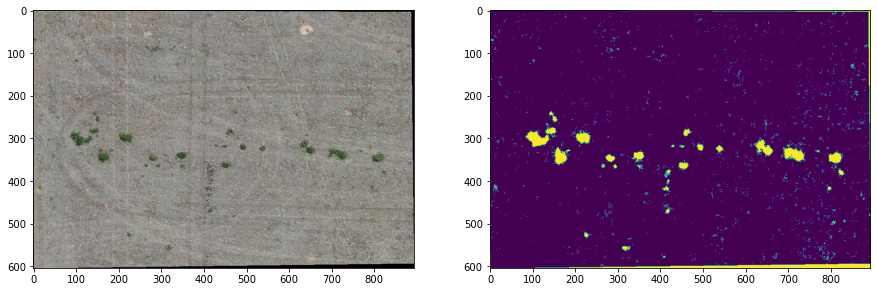

In [20]:
img_urb = img_pred > 0.5
img_vis = img_np[:,:,:3]

f, axes = plt.subplots(1, 2, figsize=(15,10))
axes[0].imshow( img_vis  )
axes[1].imshow( img_urb  )
plt.show()

# Loading model

In [21]:
model.load_weights('./model_B[0-1-2]_val_acc=0.9674.h5')

# Predicting full image

In [22]:
filename = 'Lote_3B_geo.tif'

In [23]:
# escena = GeoTiff(filename)
# escena_zc = escena.read()
# escena.crs_code

f = rasterio.open(filename)
escena_zc = f.read().transpose( (1,2,0) )

In [24]:
img_np = escena_zc[:][:,:,BANDS]
img_pred = model.predict( img_np.reshape(-1, len(BANDS)), batch_size=1024, verbose=1 )
img_pred = img_pred.reshape(img_np.shape[:2])

27806/27806 [==============================] - 127s 5ms/step


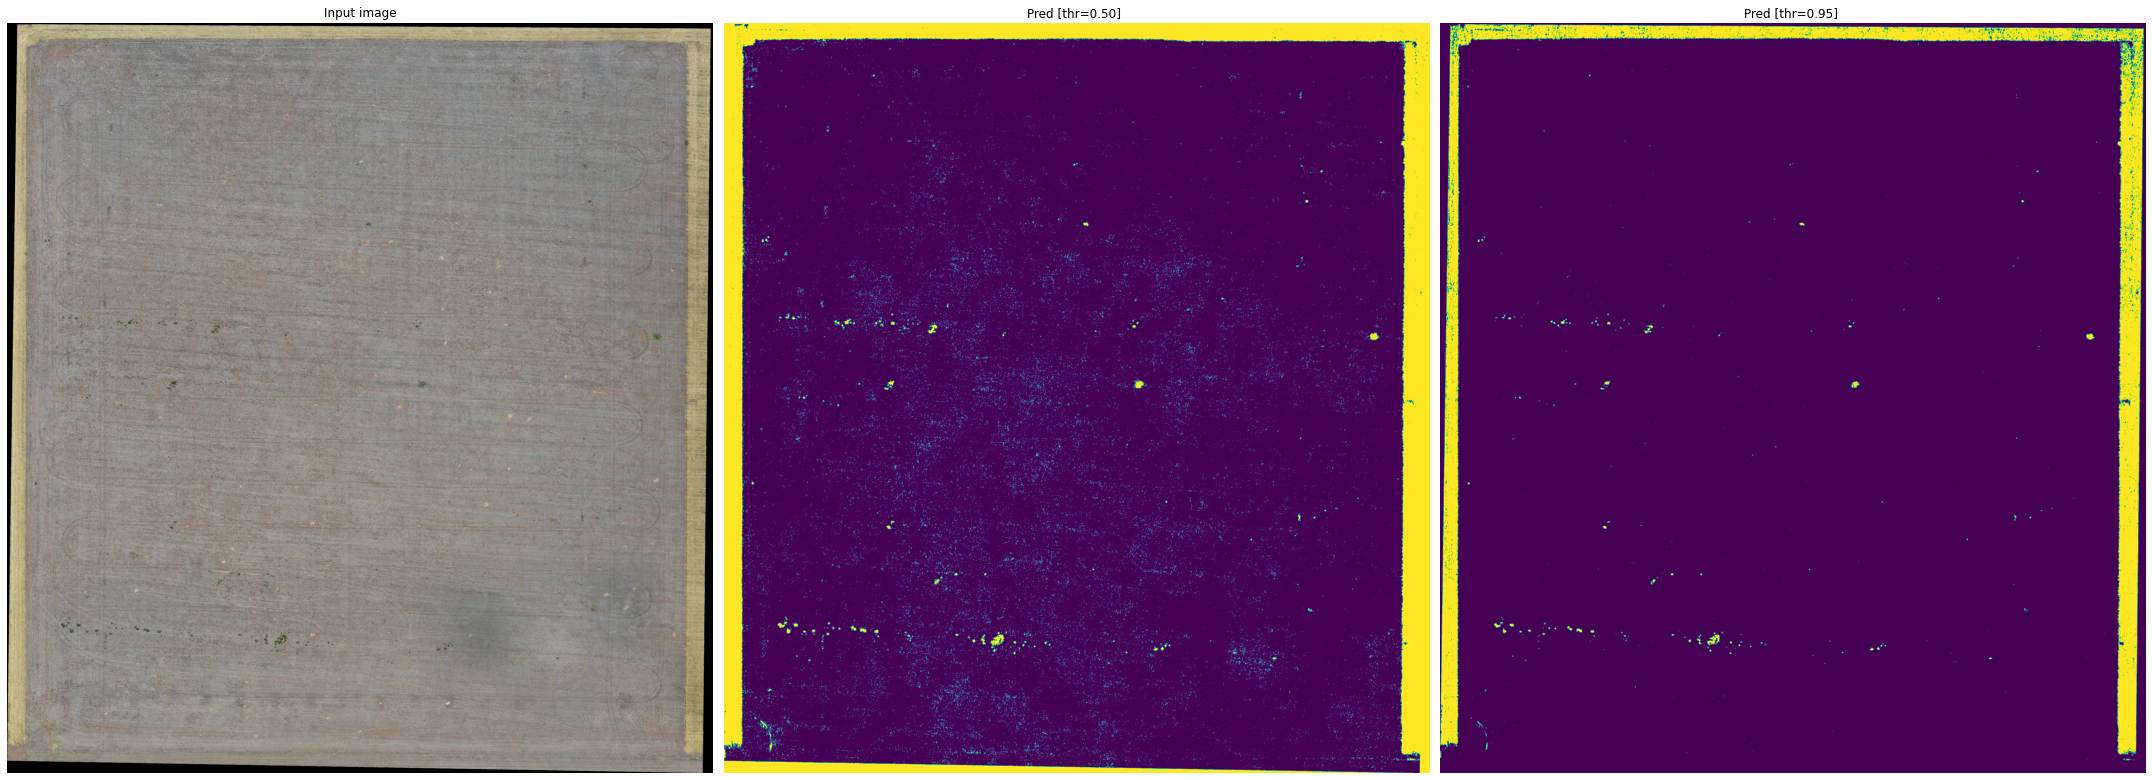

In [25]:
img_urb_50 = img_pred > 0.50
img_urb_95 = img_pred > 0.95

img_vis = img_np[:,:,:3]

f, axes = plt.subplots(1, 3, figsize=(15*2,10*2))
axes[0].imshow( img_vis  )
axes[0].axis(False)
axes[0].set_title('Input image')

axes[1].imshow( img_urb_50  )
axes[1].axis(False)
axes[1].set_title('Pred [thr=0.50] ')

axes[2].imshow( img_urb_95  )
axes[2].axis(False)
axes[2].set_title('Pred [thr=0.95] ')

plt.tight_layout()
plt.show()

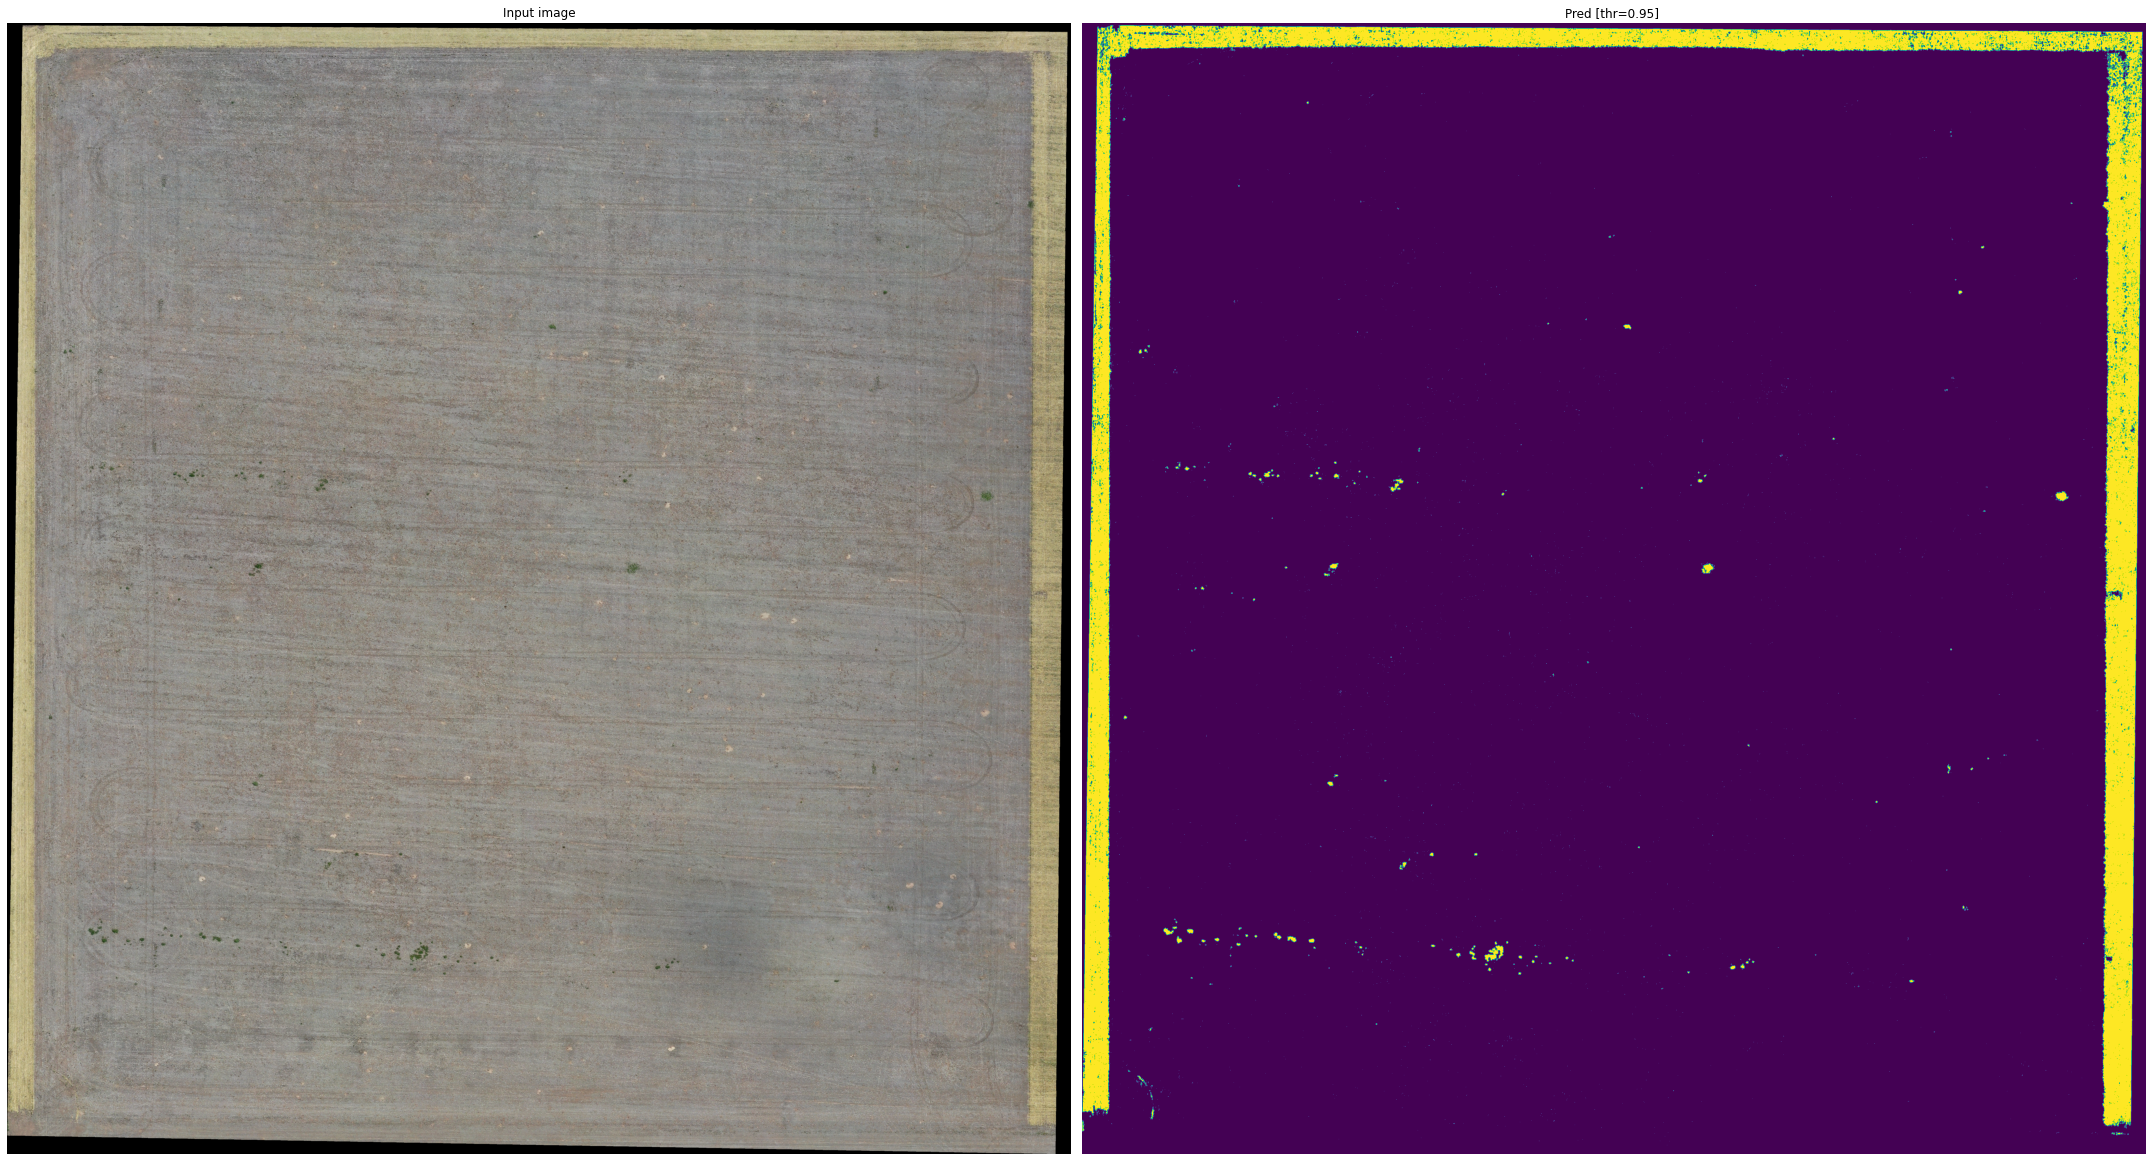

In [26]:
UMBRAL = 0.95
img_urb = img_pred > UMBRAL
img_vis = img_np[:,:,:3]

f, axes = plt.subplots(1, 2, figsize=(15*2,10*2))
axes[0].imshow( img_vis  )
axes[0].axis(False)
axes[0].set_title('Input image')

axes[1].imshow( img_urb  )
axes[1].axis(False)
axes[1].set_title(f'Pred [thr={UMBRAL:0.02f}] ')

plt.tight_layout()
plt.show()

# Salvando con georeferencia

In [ ]:
UMBRAL = 0.95

In [ ]:
ds = gdal.Open(filename)

In [ ]:
img_pred_bw_uint16 = (100 * (img_pred > UMBRAL)).astype(np.uint16)

In [ ]:
outFileName = filename.replace('.tif', f'_pred_UMBRAL={UMBRAL:0.02f}.tif')

out_array = img_pred_bw_uint16.astype(np.uint16)

[rows, cols] = out_array.shape
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(out_array)
outdata.GetRasterBand(1).SetNoDataValue(0)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!